### Libraries

In [1]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from zipfile import ZipFile
from io import BytesIO
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm import tqdm
from pytorch_msssim import ssim

### DataLoader

In [2]:
train_higher_images = '/mnt/f/datasets/SR_training_datasets/DIV2K/DIV2K_train_HR.zip'
train_lower_images = '/mnt/f/datasets/SR_training_datasets/DIV2K/DIV2K_train_LR_bicubic_X4.zip'

valid_higher_images = '/mnt/f/datasets/SR_training_datasets/DIV2K/DIV2K_valid_HR.zip'
valid_lower_images = '/mnt/f/datasets/SR_training_datasets/DIV2K/DIV2K_valid_LR_bicubic_X4.zip'

In [3]:
def train_transform():
    return Compose([
        RandomHorizontalFlip(),
        RandomVerticalFlip(),
        RandomRotation(30),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [4]:
def valid_transform():
    return Compose([
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [5]:
class ZipDataset(Dataset):
    def __init__(self, zip_file_HR, zip_file_LR, transform=None):
        self.zip_file_HR = ZipFile(zip_file_HR)
        self.zip_file_LR = ZipFile(zip_file_LR)
        self.file_list_HR = self.zip_file_HR.namelist()
        self.file_list_HR = [file for file in self.file_list_HR if file.endswith(('.png', '.jpg', '.jpeg'))]
        self.file_list_LR = self.zip_file_LR.namelist()
        self.file_list_LR = [file for file in self.file_list_LR if file.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

        self.lr_mapping = {os.path.splitext(os.path.basename(name))[0].split('x')[0]: i for i, name in enumerate(self.file_list_LR)}

    def __len__(self):
        return len(self.file_list_HR)

    def __getitem__(self, idx):
        file_HR = self.file_list_HR[idx]
        # Get the base name of the HR image
        base_name_HR = os.path.splitext(os.path.basename(file_HR))[0]
        # Find the corresponding LR image
        idx_LR = self.lr_mapping[base_name_HR]
        file_LR = self.file_list_LR[idx_LR]
        
        # printing to check the image names are same or not
        
        # print(file_HR)
        # print(file_LR)

        with self.zip_file_HR.open(file_HR) as f:
            image_HR = Image.open(BytesIO(f.read()))
        with self.zip_file_LR.open(file_LR) as f:
            image_LR = Image.open(BytesIO(f.read()))
        if self.transform:
            image_HR = self.transform(image_HR)
            image_LR = self.transform(image_LR)

        return image_LR, image_HR

#### Creating datasets

In [6]:
train_dataset = ZipDataset(train_higher_images, train_lower_images, transform=train_transform())
valid_dataset = ZipDataset(valid_higher_images, valid_lower_images, transform=valid_transform())

#### Creating datasets

In [7]:
def my_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    return [data, target]

In [8]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=my_collate)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=my_collate)

#### Testing with images

In [9]:
# iterate over the dataloader
for i, (images, labels) in enumerate(train_loader):
    # print the shapes of the images and labels
    print(f'Batch {i+1}:')
    print('Images shape:', images[0].shape)
    print('Labels shape:', labels[0].shape)
    # break the loop after the first batch
    break

Batch 1:
Images shape: torch.Size([3, 339, 510])
Labels shape: torch.Size([3, 1356, 2040])


In [10]:
def tensor_to_image(tensor):
    # Select the first image from the batch
    # 
    tensor = tensor.cuda()

    # Define the mean and std
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    # Unnormalize the tensor
    std = std.cuda()
    mean = mean.cuda()
    tensor = tensor * std + mean

    # Clamp the values in the tensor to the range [0, 1]
    tensor = torch.clamp(tensor, 0, 1)

    # Convert the tensor to a PIL Image and then convert it to a numpy array
    image = transforms.ToPILImage()(tensor).convert("RGB")
    plt.imshow(image)
    plt.show()

In [11]:
i = 1

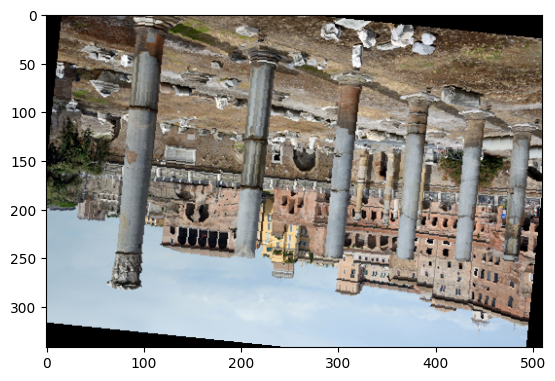

In [12]:
tensor_to_image(images[i])

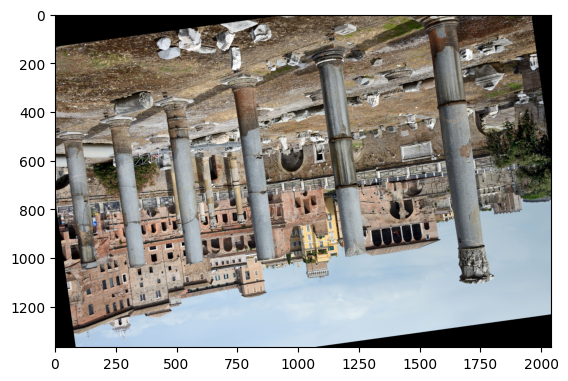

In [13]:
tensor_to_image(labels[i])

### Model with modules

#### RCAT module

In [14]:
class RCat(nn.Module):
    def __init__(self, f):
        super(RCat, self).__init__()
        self.conv1 = nn.Conv2d(f, f//4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(f, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=1, stride=1, padding=0)
        self.conv4 = nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=2)
        self.conv5 = nn.Conv2d(16, 16, kernel_size=7, stride=1, padding=3)
        self.conv6 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(f//2, f//4, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        y1 = F.relu(self.conv1(x))
        x1 = F.relu(self.conv2(x))
        x1 = F.relu(self.conv3(x1))
        x1 = F.relu(self.conv4(x1))
        x1 = F.relu(self.conv5(x1))
        x1 = F.relu(self.conv6(x1))
        c1 = torch.cat((x1, y1), dim=1)
        c2 = F.relu(self.conv7(c1))
        return c2 + y1

#### RDN module

In [15]:
class RDN(nn.Module):
    def __init__(self, f):
        super(RDN, self).__init__()
        self.conv1 = nn.Conv2d(f, f, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(f, f, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(f, f, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(f, f, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(3*f, f//4, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        y1 = self.conv1(x)
        y2 = self.conv2(y1)
        a1 = y1 + y2
        y3 = self.conv3(a1)
        a2 = y3 + a1
        y4 = self.conv4(a2)
        a3 = a1 + a2 + y4
        c = torch.cat((a1, a2, a3), dim=1)
        return self.conv5(c)

#### RUNT module

In [16]:
class Runt(nn.Module):
    def __init__(self, f):
        super(Runt, self).__init__()
        self.conv1 = nn.Conv2d(f, f, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(f, f, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(f, f//2, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(f//2, f//2, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(f//2, f//4, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(f//4, f//4, kernel_size=5, padding=2)
        self.conv7 = nn.Conv2d(f//4, f//8, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(f//8, f//8, kernel_size=5, padding=2)
        self.conv9 = nn.Conv2d(f//8, f//8, kernel_size=1)
        self.conv10 = nn.Conv2d(f//4, f//4, kernel_size=1)
        self.conv11 = nn.Conv2d(f//2, f//2, kernel_size=1)
        self.conv12 = nn.Conv2d(f, f, kernel_size=1)
        self.conv13 = nn.Conv2d(f, 3, kernel_size=1)

    def forward(self, x):
        y1 = F.relu(self.conv1(x))
        y1 = F.relu(self.conv2(y1))
        y2 = F.relu(self.conv3(y1))
        y2 = F.relu(self.conv4(y2))
        y3 = F.relu(self.conv5(y2))
        y3 = F.relu(self.conv6(y3))
        y4 = F.relu(self.conv7(y3))
        y4 = F.relu(self.conv8(y4))
        y5 = F.relu(self.conv9(y4))
        c1 = torch.cat([y5, y4], dim=1)
        y6 = F.relu(self.conv10(c1))
        c2 = torch.cat([y6, y3], dim=1)
        y7 = F.relu(self.conv11(c2))
        c3 = torch.cat([y7, y2], dim=1)
        y8 = F.relu(self.conv12(c3))
        y8 = y8 + y1
        y9 = self.conv13(y8)
        return y9

#### DEN module

In [17]:
class Den(nn.Module):
    def __init__(self):
        super(Den, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=1)
        self.actc = ACTC()  # Assuming ACTC is a defined PyTorch module
        self.mdr_inp = nn.Conv2d(64, 3, kernel_size=1) 
        self.mdsr1 = MDSR1(32)  # Assuming MDSR1 is a defined PyTorch module
        self.rdn_inp = nn.Conv2d(64, 128, kernel_size=1) 
        self.rdn = RDN(128)  # Assuming RDN is a defined PyTorch module
        self.conv4 = nn.Conv2d(102, 3, kernel_size=3, padding=2, dilation=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        f1 = self.actc(x)
        md_in = self.mdr_inp(x)
        f2 = self.mdsr1(md_in)
        rd_in = self.rdn_inp(x)
        f3 = self.rdn(rd_in)
        inp = torch.cat([f1, f2, f3, x], dim=1)
        x = self.conv4(inp)
        return x

#### ACTC module

In [18]:
class ACTC(nn.Module):
    def __init__(self):
        super(ACTC, self).__init__()
        self.conv1 = nn.Conv2d(64, 7, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 7, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 7, kernel_size=7, padding=3)
        self.conv4 = nn.Conv2d(21, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x1 = F.relu(x)
        x2 = torch.sigmoid(x)
        x3 = x2 * x
        x4 = F.softplus(x)
        x4 = torch.tanh(x4)
        x5 = x4 * x
        c1 = self.conv1(x1)
        c2 = self.conv2(x3)
        c3 = self.conv3(x5)
        cx = torch.cat([c1, c2, c3], dim=1)
        y = self.conv4(cx)
        return y

#### R1 module

In [19]:
class R1(nn.Module):
    def __init__(self, features):
        super(R1, self).__init__()
        self.conv1 = nn.Conv2d(features, features, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(features, features, kernel_size=3, padding=1)

    def forward(self, input_tensor):
        x = F.relu(self.conv1(input_tensor))
        x = self.conv2(x)
        return x + input_tensor

#### MDSR1 module

In [20]:
class MDSR1(nn.Module):
    def __init__(self, f):
        super(MDSR1, self).__init__()
        self.conv1 = nn.Conv2d(3, f, kernel_size=3, padding=1)
        self.r1 = R1(f)  # Assuming R1 is a defined PyTorch module
        self.conv2 = nn.Conv2d(4*f, 3, kernel_size=3, padding=1)

    def forward(self, ix):
        x = F.relu(self.conv1(ix))
        x1 = self.r1(x)
        x1 = self.r1(x1)
        x2 = self.r1(x)
        x2 = self.r1(x2)
        x3 = self.r1(x)
        x3 = self.r1(x3)
        x = x1 + x2 + x3
        x = torch.cat([x, x1, x2, x3], dim=1)
        x = self.conv2(x)
        return x

#### Created Custom Model

In [21]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=0, dilation=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0, dilation=4)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=1, padding=0, dilation=16)
        self.den_inp = nn.Conv2d(64, 3, kernel_size=1) 
        self.den = Den()  # Assuming Den is a defined PyTorch module
        self.runt_inp = nn.Conv2d(64, 16, kernel_size=1) 
        self.runt = Runt(16)  # Assuming Runt is a defined PyTorch module
        self.conv4 = nn.Conv2d(6, 3, kernel_size=1, padding=1, dilation=8)  # Adjusted number of input channels
        self.runt_inp2 = nn.Conv2d(3, 32, kernel_size=1)
        self.runt2 = Runt(32)  # Assuming Runt is a defined PyTorch module
        self.conv5 = nn.Conv2d(6, 3, kernel_size=1, padding=1, dilation=8)  # Adjusted number of input channels

    def forward(self, input_im):
        x = F.relu(self.conv1(input_im))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        den_in = self.den_inp(x) 
        x1 = self.den(den_in)
        runt_in = self.runt_inp(x)
        x2 = self.runt(runt_in)
        x = torch.cat([x1, x2], dim=1)
        # print(x.shape)
        x = F.relu(self.conv4(x))
        x1 = self.den(x)
        runt_in = self.runt_inp2(x)
        x2 = self.runt2(runt_in)
        x = torch.cat([x1, x2], dim=1)
        y = self.conv5(x)
        # Upsample the output to be 4 times the size of the input
        y = F.interpolate(y, scale_factor=4, mode='bicubic', align_corners=False)
        return y

### Training part

#### Custom Losses

##### Smoothing Loss

In [22]:
class SmoothingLoss(nn.Module):
    def __init__(self):
        super(SmoothingLoss, self).__init__()

    def forward(self, prediction, target):
        # Apply smoothing to the target
        target_smooth = self.smooth_target(target)

        # Compute the absolute difference between the prediction and the smoothed target
        diff = torch.abs(target_smooth - prediction)

        # Compute the loss as the mean of the absolute differences
        loss = torch.mean(diff)
        return loss

    def smooth_target(self, target):
        # Apply Gaussian filter
        gaussian_filter = torch.tensor([[1., 2., 1.], [2., 4., 2.], [1., 2., 1.]]) / 16.0
        gaussian_filter = gaussian_filter.repeat(target.shape[1], 1, 1, 1).to(target.device)
        target_smooth = F.conv2d(target, gaussian_filter, padding=1, groups=target.shape[1])

        # Apply consecutive upsampling and downsampling
        target_smooth = F.interpolate(target_smooth, scale_factor=2, mode='bilinear', align_corners=False)
        target_smooth = F.interpolate(target_smooth, scale_factor=0.5, mode='bilinear', align_corners=False)

        return target_smooth

##### SSIM Loss

In [23]:
def calculate_ssim(y_true, y_pred, data_range):
    # Calculate SSIM
    ssim_val = ssim(y_true, y_pred, data_range=data_range, size_average=True)
    
    # Return SSIM value
    return ssim_val

#### Parameter Setting

In [41]:
# Instantiate the model
model = MyModel()

# Define a loss function
mse_criterion = nn.MSELoss()
smoothing_criterion = SmoothingLoss()

# Define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

num_epochs = 80

if torch.cuda.is_available():
    device = torch.device('cuda')  # Default CUDA device
    num_gpus = torch.cuda.device_count()
    print(f'{num_gpus} GPUs available')

    model = nn.DataParallel(model)  # Use multiple GPUs
    model.to(device)
else:
    print('CUDA is not available.')

1 GPUs available


#### Training loop

In [40]:
min_val_loss = float('inf')
best_model_path = None

#####  Only run the following cell if there is a weight avilable

In [39]:
# weights_path = './weights/model_epoch_7_val_loss_0.06323117017745972.pth' 
weights_path = './weights/model_asms_epoch_1_val_loss_1.84092.pth' 

# Load the weights into the model
model.load_state_dict(torch.load(weights_path))

# if torch.cuda.is_available():
#     model = model.cuda()

<All keys matched successfully>

In [42]:
for epoch in range(num_epochs):
    # Training phase
    model.train()  
    for i, (inputs, targets) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}")):
        for input1, target in zip(inputs, targets):
            if torch.cuda.is_available():
                input1 = input1.to(device)
                target = target.to(device)

            output = model(input1.unsqueeze(0))

            # Compute the smoothing loss
            smoothing_loss = smoothing_criterion(output, target.unsqueeze(0))

            # Compute the mean squared error loss
            mse_loss = mse_criterion(output, target.unsqueeze(0))

            # SSIM loss
            ssim_loss = 1 - calculate_ssim(output, target.unsqueeze(0), 1.0)

            # Combine the losses
            loss = smoothing_loss + mse_loss + ssim_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    print(f'Training Loss: {loss.item()}')
    
    # Validation phase
    model.eval()  
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(valid_loader):
            for input1, target in zip(inputs, targets):
                if torch.cuda.is_available():
                    input1 = input1.to(device)
                    target = target.to(device)

                output = model(input1.unsqueeze(0))

                # Compute the validation loss
                val_loss = smoothing_criterion(output, target.unsqueeze(0)) + mse_criterion(output, target.unsqueeze(0)) + (1 - calculate_ssim(output, target.unsqueeze(0), 1.0))

    print(f'Validation Loss: {val_loss.item()}')
    
    scheduler.step(val_loss.item())
    
    if val_loss.item() < min_val_loss:
        min_val_loss = val_loss.item()

        if not os.path.exists('./weights'):
            os.makedirs('./weights')
        
        if best_model_path is not None:
            os.remove(best_model_path)
        
        # Save the new best model and update the best model path
        best_model_path = f'./weights/model_asms_epoch_{epoch+1}_val_loss_{val_loss.item():.5f}.pth'
        torch.save(model.state_dict(), best_model_path)

Training Epoch 1/80:   0%|          | 0/200 [00:00<?, ?it/s]

Training Epoch 1/80:  12%|█▏        | 23/200 [01:10<08:12,  2.78s/it]

#### Checking the output

In [36]:
weights_path = './weights/kaggmodel_asms_epoch_15_val_loss_2.34369.pth' 
# weights_path = best_model_path

# Load the weights into the model
model.load_state_dict(torch.load(weights_path))

# if torch.cuda.is_available():
#     model = model.cuda()

<All keys matched successfully>

#### Testing with set5

In [27]:
lower_image_dir = '/mnt/f/datasets/classical_SR_datasets/Set5/LRbicx4' 
original_image_dir = '/mnt/f/datasets/classical_SR_datasets/Set5/original' 

In [28]:
lower_image_files = [f for f in os.listdir(lower_image_dir) if f.endswith('.jpg') or f.endswith('.png')]
original_image_files = [f for f in os.listdir(original_image_dir) if f.endswith('.jpg') or f.endswith('.png')]

In [29]:
lower_images = [Image.open(os.path.join(lower_image_dir, f)) for f in lower_image_files]
original_images = [Image.open(os.path.join(original_image_dir, f)) for f in original_image_files]

In [30]:
i = 3

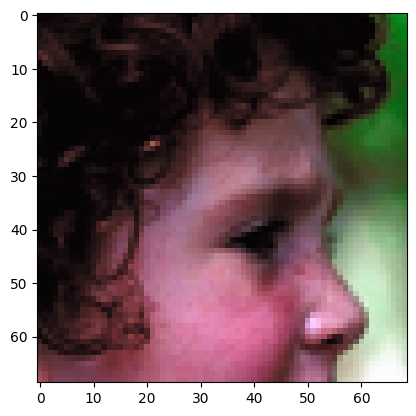

In [31]:
plt.imshow(lower_images[i])

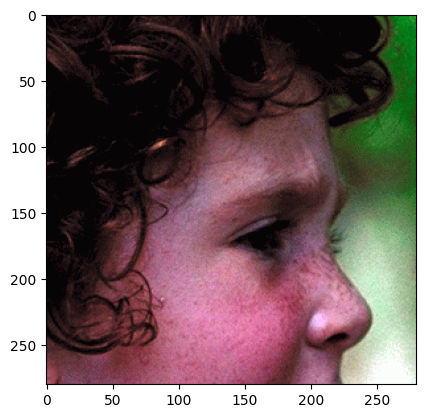

In [32]:
plt.imshow(original_images[i])

In [33]:
trans = valid_transform()
test = trans(lower_images[i])
test = test.unsqueeze(0)
test = test.cuda()
test.shape

torch.Size([1, 3, 69, 69])

In [ ]:
out = model(test)

out.shape

torch.Size([1, 3, 276, 276])

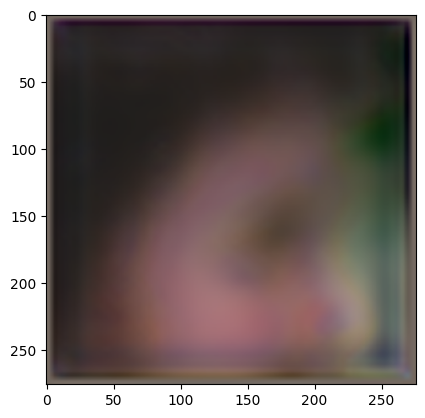

In [35]:
tensor_to_image(out[0])

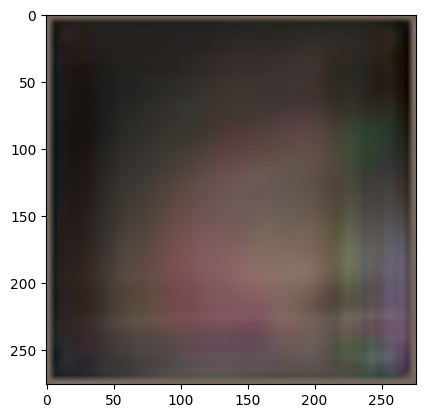

In [ ]:
tensor_to_image(out[0])

In [ ]:
# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")